In [79]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.morphology import remove_small_holes, area_opening, skeletonize, area_closing, dilation, erosion, binary_dilation, binary_closing, binary_erosion, binary_opening
import pandas as pd
from matplotlib import rcParams
import skimage.io
from skimage.filters import threshold_yen, try_all_threshold, threshold_minimum, sobel, gaussian


In [2]:
THRESHOLD = 100
MAX_PIXEL_VALUE = 255

# COLOR = 'black'
plt.style.use("default")
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['figure.figsize'] = (15, 10)
rcParams['figure.titlesize'] = 20
rcParams['figure.dpi'] = 50
# rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = 'lightgray'
rcParams['legend.fontsize'] = 25
rcParams['axes.titlesize'] = 60
rcParams['axes.labelsize'] = 50
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
# rcParams['text.color'] = COLOR
# rcParams['text.color'] = COLOR
# rcParams['axes.labelcolor'] = COLOR
# rcParams['xtick.color'] = COLOR
# rcParams['ytick.color'] = COLOR
# rcParams['grid.color'] = COLOR
rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

In [3]:
def cortar(frame, limites, PRUEBA=False, nombre='CORTE'):
    # lee en gris
    min_x, max_x, min_y, max_y = limites
    corte = frame[min_y:max_y, min_x:max_x] # resolver lo del corte binarizadp
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', corte)
    return corte

def gris(frame, PRUEBA=False, nombre='GRAYSCALE'):
    im_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_gray)
    return im_gray

def binarize(frame, th=THRESHOLD, PRUEBA=False, nombre='BINARY'):
    _, im_binary = cv.threshold(frame, th, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def skeleton(frame, PRUEBA=False, nombre='ESQUELETO'):
    arr = frame < 255 #Convert frame to binary mask of 1's and 0's
    sk = skeletonize(arr)*255 #We apply skeletonize to boolean mask and upscale 1's to 255 (white)
    _, x = np.where(sk!=0)
    # esto cierra los globitos, es lo que faltaba antes:
    # for c in np.unique(x):
    #     r = np.where(sk[:, c]!=0)[0]
    #     for p in r:
    #         sk[p, c] = 0
    #     sk[int(np.mean(r)), c] = 255
    tail = np.where(sk!=0)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', sk)
    return sk, tail

In [4]:
FILENAME='P1-2V-9Hz'

In [5]:
vs = cv.VideoCapture(f'videos/FCD/P1/{FILENAME}.mp4')
i=0
while(vs.isOpened()):
    ret, frame = vs.read()
    if ret: 
        if i==0:
            ref_frame = gris(frame)
        cv.imshow('frame', frame)
        i+=1
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv.destroyAllWindows()

In [25]:
ref_frame[559:690,1120:1241] = MAX_PIXEL_VALUE

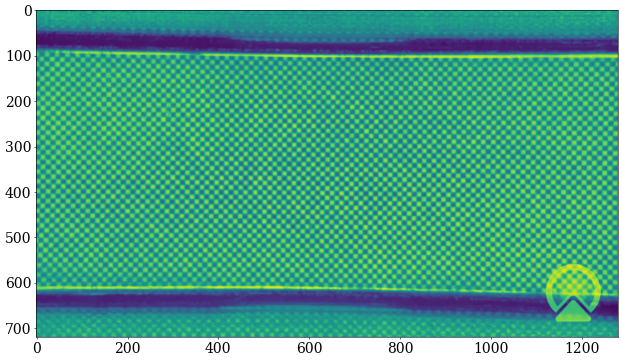

In [183]:
plt.imshow(ref_frame)

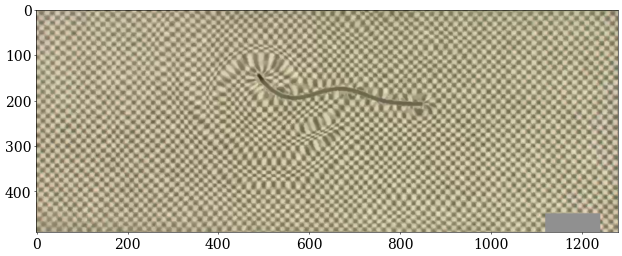

In [6]:
camo_mask = [559,690,1120,1241] # ymin, ymax, xmin, xmax

vs = cv.VideoCapture(f'videos/FCD/P1/{FILENAME}.mp4')
i=0
while(vs.isOpened()):
    ret, frame = vs.read()
    if ret:
        frame[camo_mask[0]:camo_mask[1],camo_mask[2]:camo_mask[3]] = np.mean(frame)
        # frame = gris(frame[110:600,:])
        frame = frame[110:600,:]
        if i==540:
            ref_frame = frame
        cv.imshow('frame', frame)
        i+=1
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv.destroyAllWindows()
plt.imshow(ref_frame)

# Pruebas de una captura

In [7]:
skimage.io.imsave(f'capture-{FILENAME}-color.tiff', ref_frame)

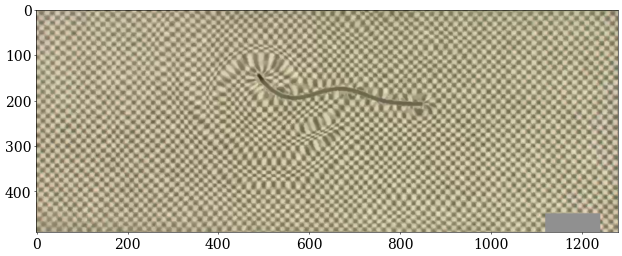

In [89]:
im = skimage.io.imread(f'capture-{FILENAME}-color.tiff')
plt.imshow(im)
im_copy = im.copy()

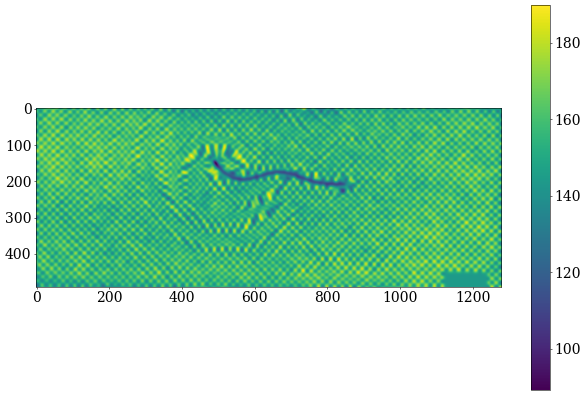

In [90]:
# ref_sobel = sobel(im)
ref_gray = gris(im)

ref_gaussian = gaussian(ref_gray, 4)*255

plt.figure()
plt.imshow(ref_gaussian)
plt.colorbar()


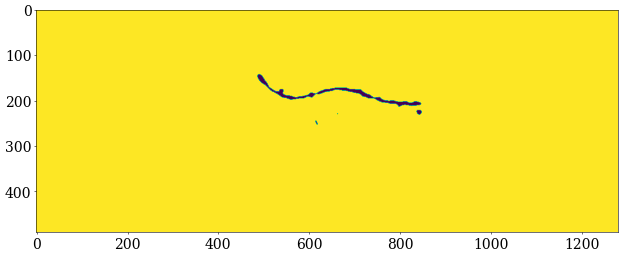

In [91]:

ref_binary = binarize(ref_gaussian, th=120)

plt.figure()
plt.imshow(ref_binary)

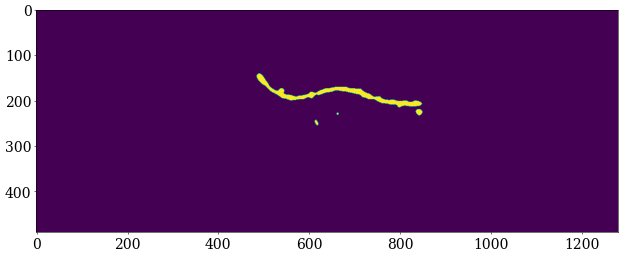

In [110]:
ref_clear = binary_erosion(ref_binary)
ref_clear = binary_erosion(ref_clear)
ref_clear_mask = 1-binary_opening(ref_clear)
ref_clear = ref_clear_mask*255
# ref_clear = cv.bitwise_not(ref_clear)

plt.figure()
plt.imshow(ref_clear)

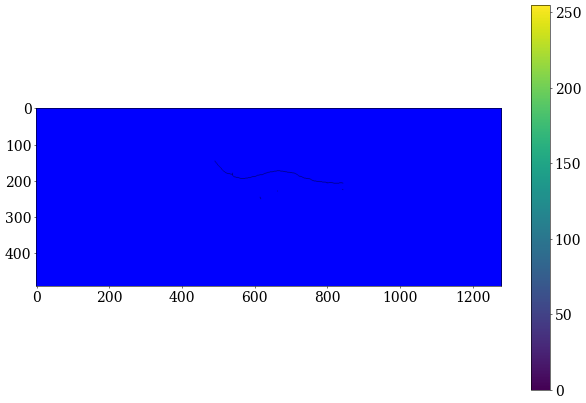

In [113]:
ref_sk = skeletonize(ref_clear)
y, x = np.where(ref_sk!=0)
im_copy[y, x] = 

plt.figure()
plt.imshow(im_copy)
plt.colorbar()

# Automatización

In [ ]:
camo_mask = [559,690,1120,1241] # ymin, ymax, xmin, xmax
lim = [110,600]

In [ ]:
def filtrado(frame):
    frame = gris(frame)
    frame = gaussian(frame, 4)*255
    frame = binarize(frame, th=120)
    frame = binary_erosion(frame)
    frame = binary_erosion(frame)
    frame = (1-binary_opening(frame))*255
    return frame
    

def tracker(vs, camo, lim, SHOW=False):
        # coordenadas de la cola en cada frame      
        pos_sk = []
        pos_tail = []
        lista_count=[]
        while(vs.isOpened()):
            ret, frame = vs.read()
            if ret:
                count +=1
                frame = frame[lim[0]:lim[1], :]
                filtrado(frame)

                # para que sólo tome cuando la cola está completa:
                im_izq = frame[:, 0:1]
                im_izq = cv.bitwise_not(binarize(gris(im_izq), th=100))
                im_der = frame[:, -2:-1]
                im_der = cv.bitwise_not(binarize(gris(im_der), th=160))
                if np.sum(im_izq) == 0:
                    if np.sum(im_der) == 0:
                        lista_count.append(count)
                        frame_bn = binarize_TAIL(guillotina(gris(frame)))
                        x_tail, y_tail = np.where(frame_bn==0)
                        sk, tail = skeleton(frame_bn)
                        pos_sk.append(sk)
                        pos_tail.append(tail)
                        if SHOW:
                            # frame[tail[0],tail[1]] = [0, 0, 255]
                            frame[x_tail,y_tail] = [0, 0, 255]                            
                            cv.imshow('frame', frame)
                        i+=1
                        if cv.waitKey(1) & 0xFF == ord('q'):
                            break
                else:
                    print('termina en:',count)
                    break
            else:
                print('Video no leído')
                break
        cv.destroyAllWindows()
        tiempo = [f for f in range(1, len(pos_sk)+1)]

        return i, lista_count, np.array(tiempo, dtype='object'), np.array(pos_sk, dtype='object'), np.array(pos_tail, dtype='object')

# Pruebas código de Pablo

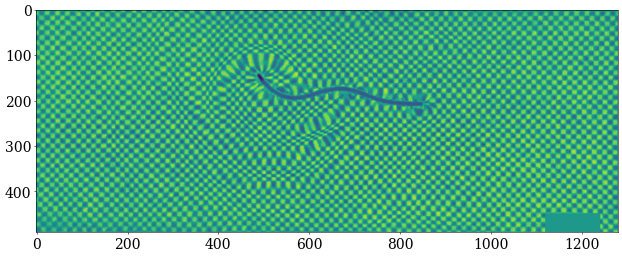

In [293]:
im = skimage.io.imread(f'capture-{FILENAME}.tiff')
# im = skimage.io.imread('P1-capture.jpg')
# im = np.mean(im[100:600,:,:],axis=2)
plt.imshow(im)

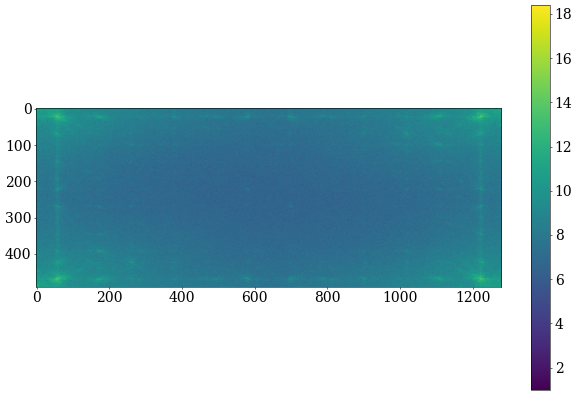

In [294]:
ft = np.fft.fft2(im)
plt.figure()
plt.imshow(np.log(np.abs(ft)))
plt.colorbar()

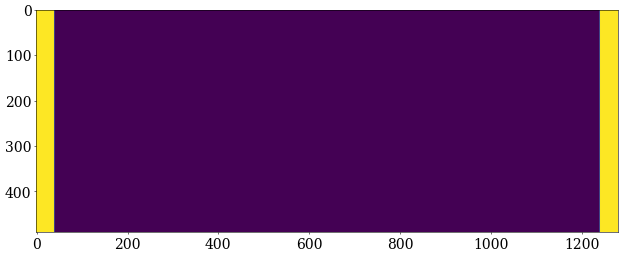

In [322]:
filt = np.zeros_like(im)
# esto es robusto: el filtro puede cambiar ancho entre 10 y 50!
# N = 10
N = 40
filt[:,0:N] = 1
filt[:,-N:] = 1
plt.imshow(filt)

C:\Users\pauli\AppData\Local\Temp\ipykernel_20316\98459067.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  rec = np.fft.ifft2(ftf).astype(float)


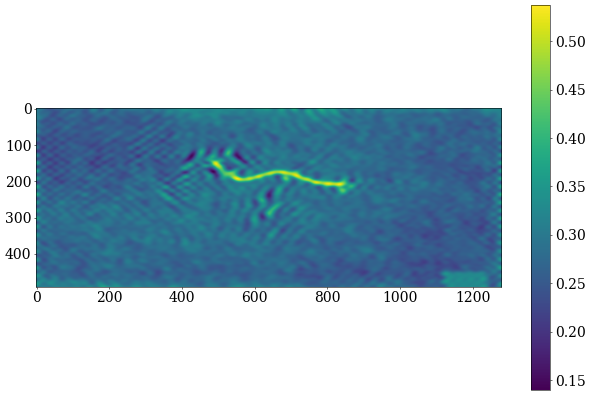

In [378]:
# vamos con la FTP 2D
ftf = ft*filt
# plt.imshow(ftf)
rec = np.fft.ifft2(ftf).astype(float)
rec = rec/np.max(rec)

rec = 1-rec
rec = skimage.morphology.dilation(rec)
# rec = skimage.morphology.dilation(rec)
rec = skimage.filters.gaussian(rec, 4)
# rec = skimage.filters.roberts(rec)
# rec = skimage.morphology.dilation(rec)
# rec = skimage.morphology.dilation(rec)
plt.figure()
plt.imshow(rec)
plt.colorbar()

0.4542823176748049


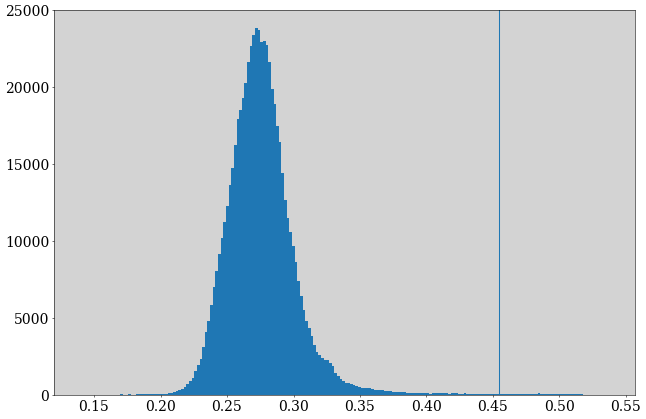

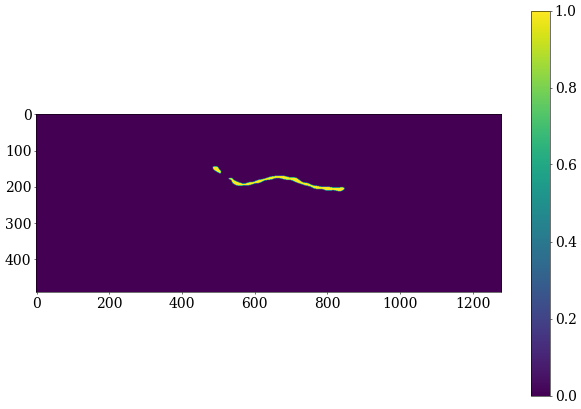

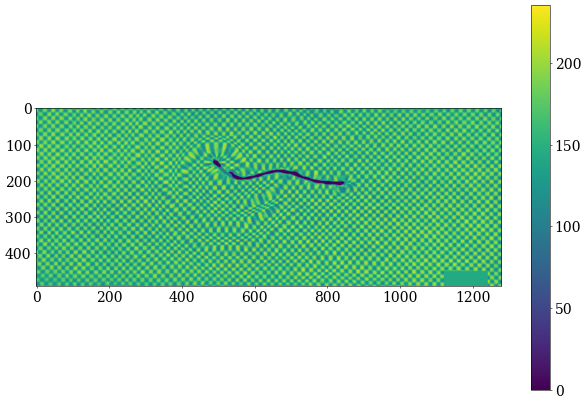

In [383]:
th = threshold_minimum(rec) 
th1 = th - 0.05
# th = 0.5

print(th)
plt.figure()
plt.hist(rec.flatten(), 200)
plt.axvline(th)

binary = rec>th
# binary = skimage.morphology.dilation(binary)
# binary = skimage.morphology.dilation(binary)
# binary = skimage.morphology.dilation(binary)
# binary = skimage.morphology.area_closing(binary, 2000)
plt.figure()
# area_
plt.imshow(binary)
plt.colorbar()

plt.figure()
plt.imshow(im*(1-(rec>th)))
plt.colorbar()
